<a href="https://colab.research.google.com/github/channeladam/MOOCs/blob/master/SchoolOfAI/DataLit/Week04/W4_7_Homework_Kaggle_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

import scipy as sp
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.core.pylabtools import figsize

import warnings
warnings.filterwarnings('ignore')

# Data Acquisition

In [2]:
!wget -N "https://raw.githubusercontent.com/channeladam/MOOCs/master/SchoolOfAI/DataLit/Week04/data/train.csv"

--2019-02-26 14:44:16--  https://raw.githubusercontent.com/channeladam/MOOCs/master/SchoolOfAI/DataLit/Week04/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 449.88K  --.-KB/s    in 0.04s   

Last-modified header missing -- time-stamps turned off.
2019-02-26 14:44:17 (12.2 MB/s) - ‘train.csv’ saved [460676/460676]



# *Exploratory* Data Analysis

Read the data dictionary: https://raw.githubusercontent.com/channeladam/MOOCs/master/SchoolOfAI/DataLit/Week04/data/data_description.txt

## Training Data

In [0]:
train = pd.read_csv('train.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Notes:

* Lots of objects / strings / categorical variables - as per the data dictionary.
* 81 columns, but:
  * Kaggle comp said there were 79 variables... 
  * SalePrice accounts for one
  * Id column is the extra one...
  
Columns that I think might be more important:

Scalar:

* LotArea
* LotFrontage
* OverallQual
* OverallCond
* TotalBsmtSF
* GrLivArea


Cat:

* MSZoning
* Utilities
* Neighborhood
* BldgType
* HouseStyle
* ExterQual
* ExterCond
* too many!


In [6]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

SalePrice:

* mean ~=  180k
* std     ~=  80k

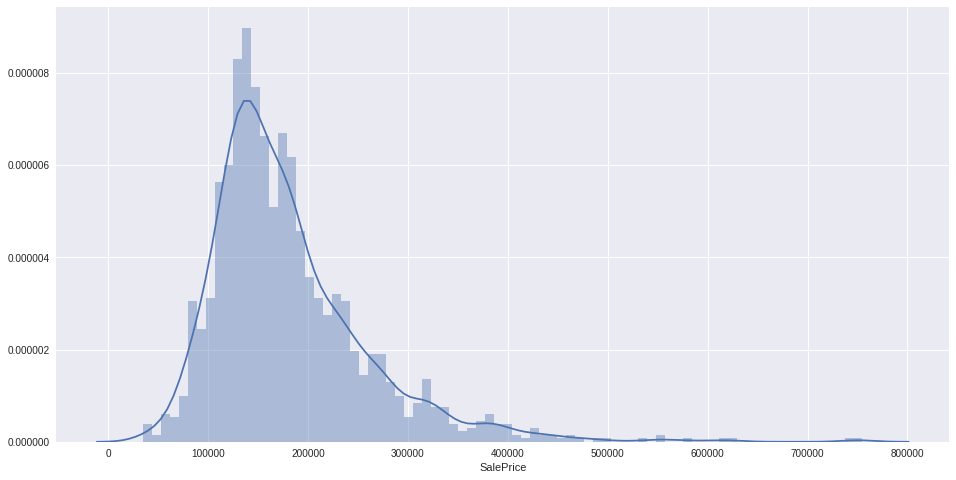

In [7]:
figsize(16,8)
sns.distplot(train['SalePrice'], hist=True, bins=int(800000/10000))

Notes:

* this is not a normal distribution

### Correlation

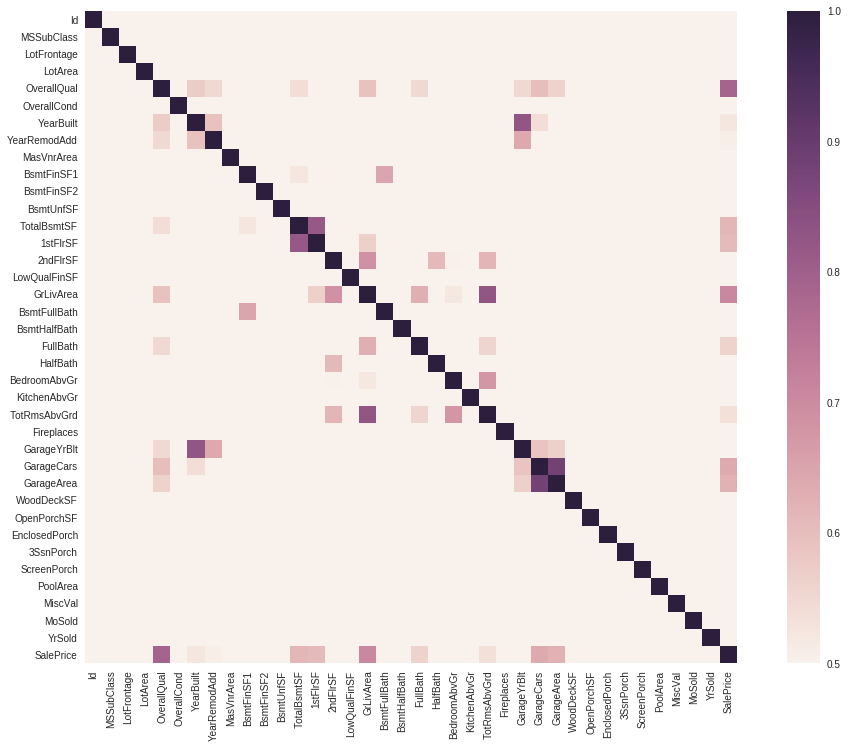

In [8]:
corrmatrix = train.corr(method='pearson')
f, ax = plt.subplots(figsize=(18,12))
sns.heatmap(corrmatrix, vmin=0.5, square=True)

Of interest:
* SalePrice & OverallQual, GrLivArea, GarageCars, and then: GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, YearBuilt


Examples of things that make sense:
* GarageCars is correlated with GarageArea - collinear? One of these can be dropped
* TotalBsmntSF and 1stFlrSF - collinear? One of these can be dropped
* GrLivArea is correlated with TotRmsAbvGrd - collinear? One of these can be dropped
* Year built is correlated with GarageYrBuilt


In [9]:
largest_saleprice_corrs = corrmatrix.nlargest(10, 'SalePrice')['SalePrice']
largest_saleprice_corrs

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

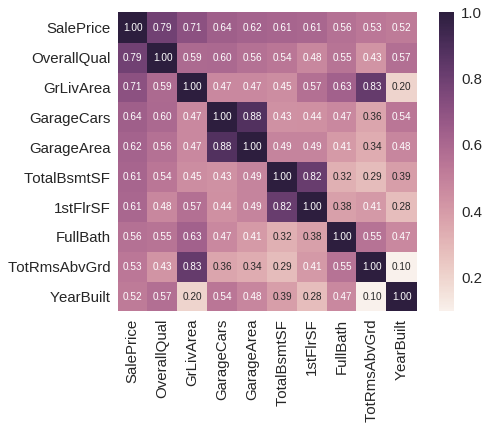

In [10]:
cols = largest_saleprice_corrs.index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [0]:
best_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

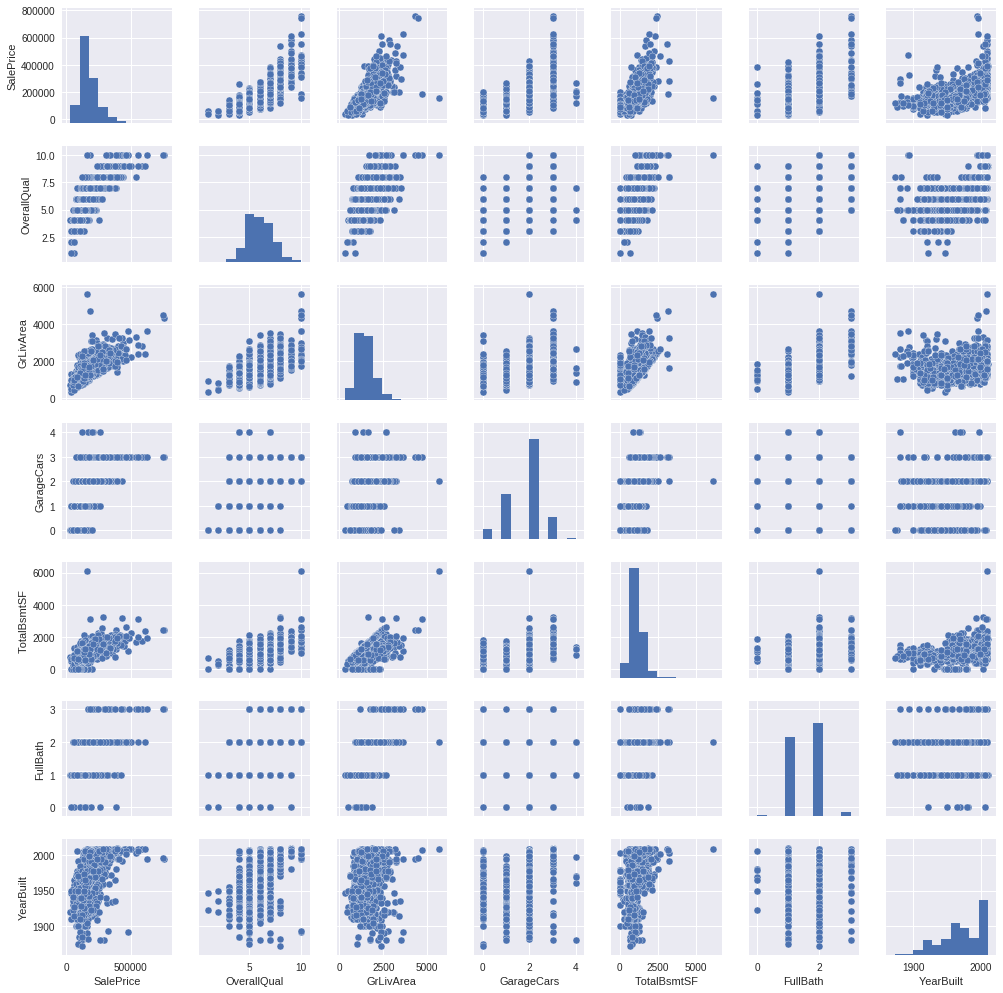

In [12]:
# Scatterplot
sns.set()
sns.pairplot(train[best_cols], size = 2)
plt.show()

# Data Cleansing

## Training Data

In [13]:
train.shape

(1460, 81)

In [14]:
missing = pd.DataFrame({ "Count": train.isnull().sum().sort_values(ascending=False)})
missing[:20]

,Count
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageCond,81
GarageType,81
GarageYrBlt,81
GarageFinish,81


According to the EDA and correlations, none of those fields appear important... so drop them all...

In [15]:
todrop = missing[missing['Count'] > 0]
cols_to_drop = todrop.index.get_values().tolist()
cols_to_drop.append("Id")
cols_to_drop

['PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'LotFrontage',
 'GarageCond',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'BsmtExposure',
 'BsmtFinType2',
 'BsmtFinType1',
 'BsmtCond',
 'BsmtQual',
 'MasVnrArea',
 'MasVnrType',
 'Electrical',
 'Id']

### Check for normal distributions for linear regression

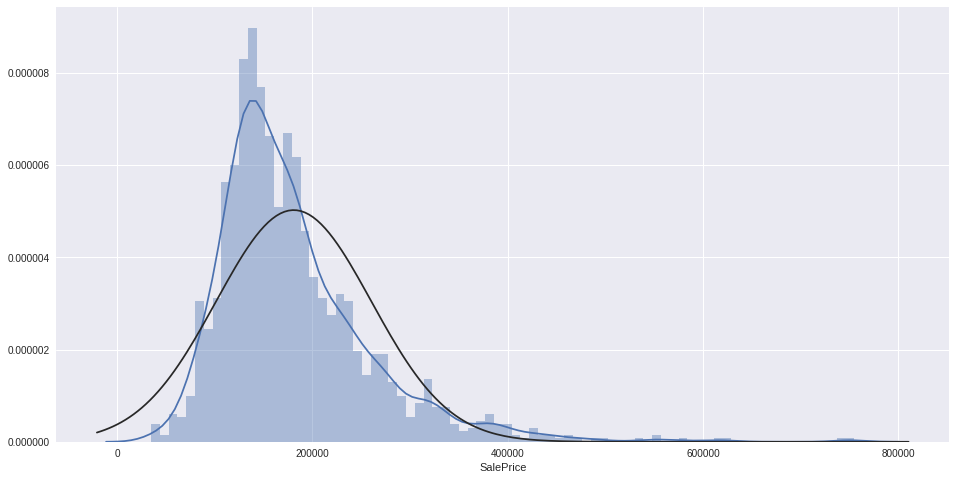

In [16]:
figsize(16,8)
sns.distplot(train['SalePrice'], hist=True, bins=int(800000/10000), fit=norm)

**SKEWED**

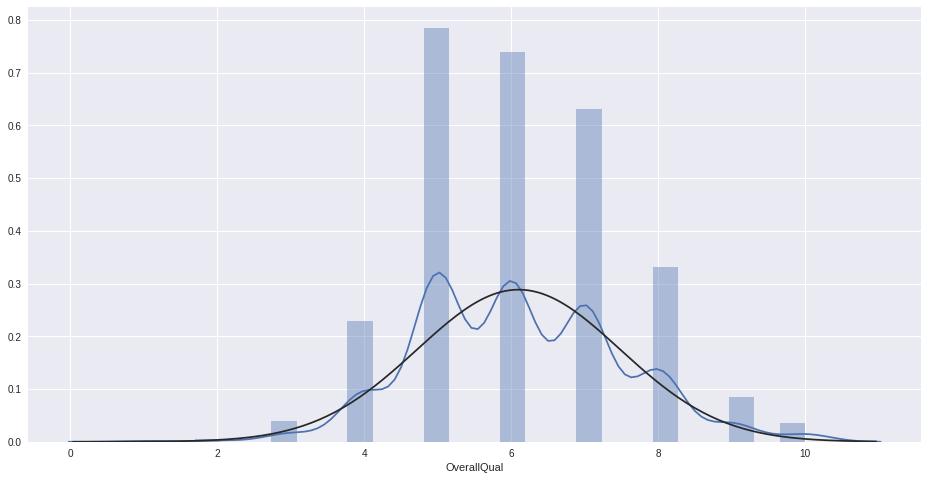

In [17]:
# best_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

sns.distplot(train['OverallQual'], hist=True, fit=norm) #, bins=int(800000/10000))

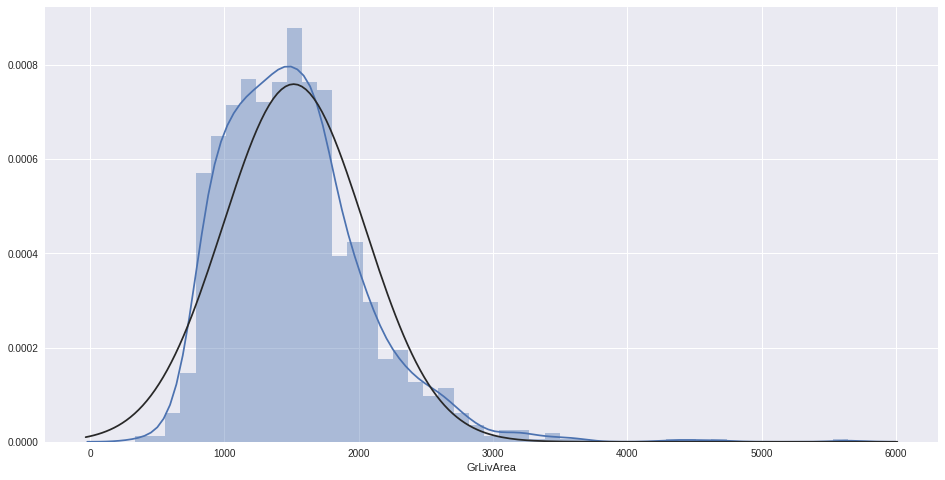

In [18]:
sns.distplot(train['GrLivArea'], hist=True, fit=norm)

**SKEWED**

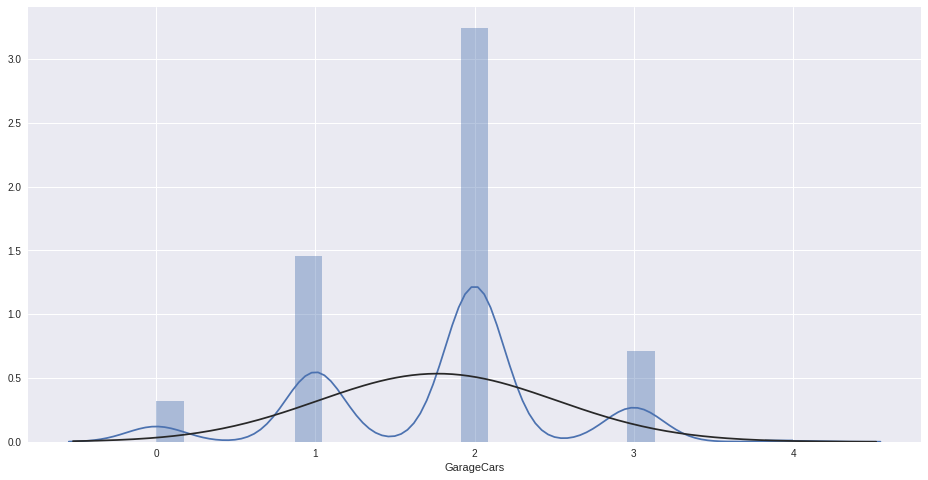

In [19]:
sns.distplot(train['GarageCars'], hist=True, fit=norm)

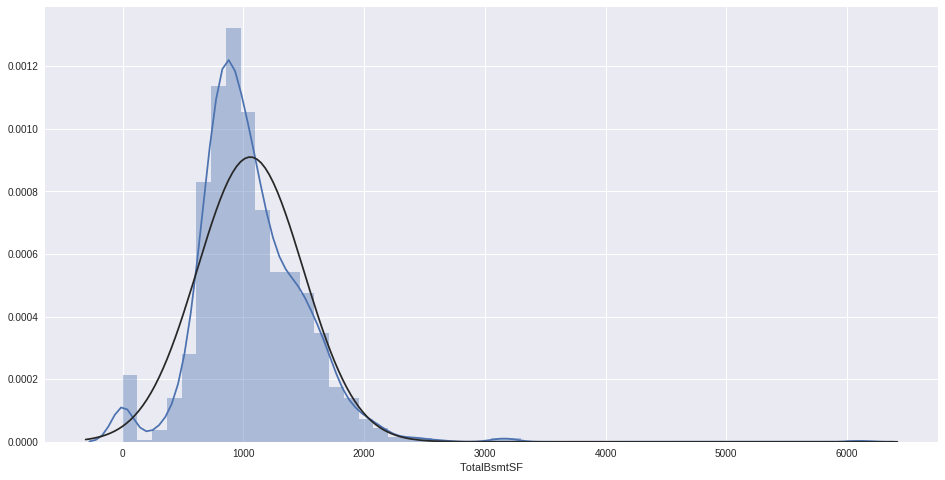

In [20]:
sns.distplot(train['TotalBsmtSF'], hist=True, fit=norm)

**SKEWED**

Many zero values / houses without basements - which are no good for a fix with log()

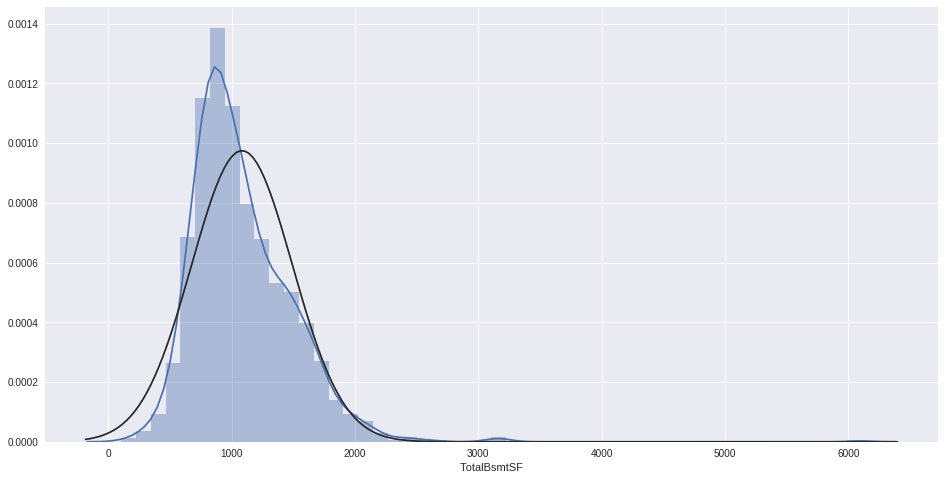

In [21]:
sns.distplot(train[ train['TotalBsmtSF']>0 ]['TotalBsmtSF'], hist=True, fit=norm)

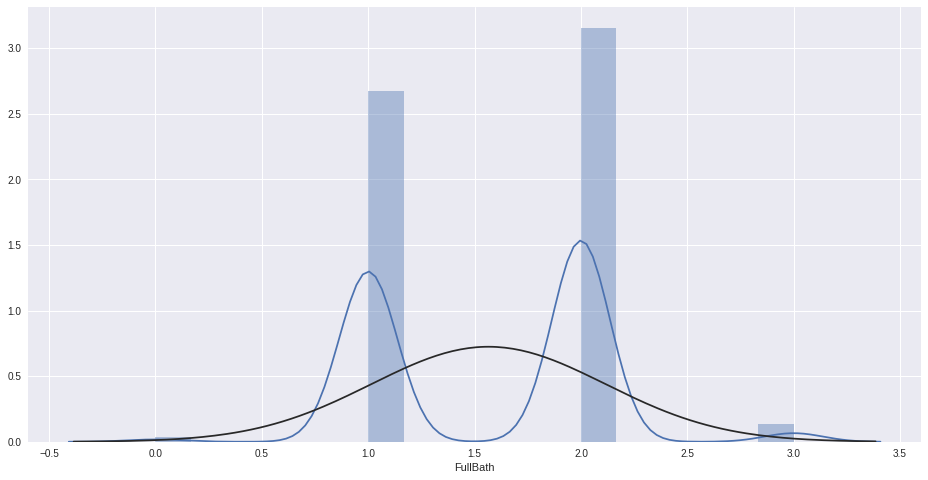

In [22]:
sns.distplot(train['FullBath'], hist=True, fit=norm)

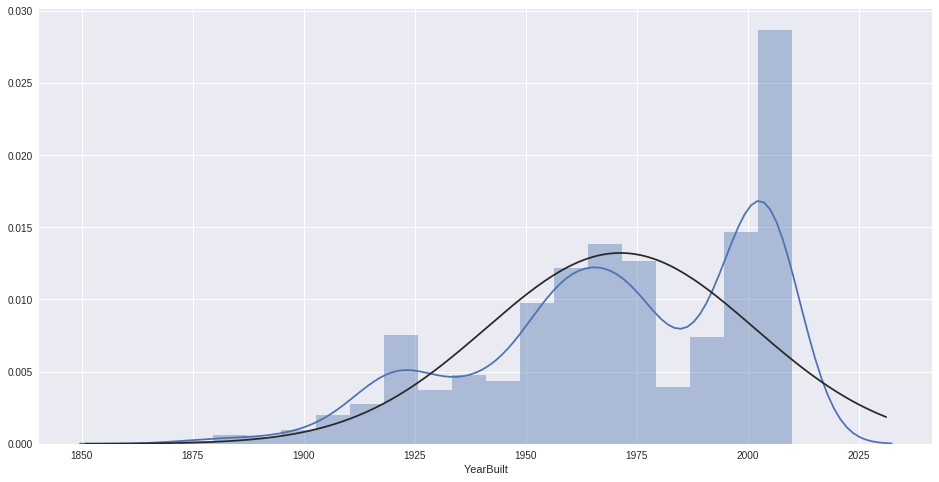

In [23]:
sns.distplot(train['YearBuilt'], hist=True, fit=norm)

In [0]:
def clean_data(df, cols_to_drop):
  
    df = df.drop(cols_to_drop, axis=1, inplace=False)

    # TODO: NOTE: just doing the median here is INACCURATE... 
    # But I don't have enough time to determine what columns should be set to zero, the mean, the median or something else
    # So we'll just set them to the median for now...  
    num_vars = df.select_dtypes(include=['int64','float']).columns
    df[num_vars] = df[num_vars].apply(lambda x: x.fillna(x.median()), axis=0)
  
    cat_vars = df.select_dtypes(include='object').columns
    df[cat_vars] = df[cat_vars].apply(lambda x: x.fillna("UNKNOWN"), axis=0)

    # handle positive skewed data - log should help normalise it
    # TODO: Consider log1p
    df['SalePrice'] = np.log(df['SalePrice'])
    df['GrLivArea'] = np.log(df['GrLivArea'])
    
    # Handle TotalBsmntSF which is positively skeweed but also has many zero values that are no good for log()
    df['HasTotalBsmtSF'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
    df['HasTotalBsmtSF'] = 0 
    df.loc[df['TotalBsmtSF']>0, 'HasTotalBsmtSF'] = 1
    df.loc[df['HasTotalBsmtSF']==1, 'TotalBsmtSF'] = np.log(df['TotalBsmtSF'])
    
    # Convert categorical vars to a column per category value
    return pd.get_dummies(df)


In [27]:
train = clean_data(train, cols_to_drop)
train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,706,0,150,6.752270,...,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,978,0,284,7.140453,...,0,0,0,1,0,0,0,0,1,0
2,60,11250,7,5,2001,2002,486,0,434,6.824374,...,0,0,0,1,0,0,0,0,1,0
3,70,9550,7,5,1915,1970,216,0,540,6.628041,...,0,0,0,1,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,655,0,490,7.043160,...,0,0,0,1,0,0,0,0,1,0


In [28]:
train.shape

(1460, 217)

In [29]:
train.columns[0:100]

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'HasTotalBsmtSF',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mo

# Regression

In [0]:
def predict_metrics(model, x, y):
    pred = model.predict(x)
    mae = mean_absolute_error(y, pred)
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    return mae, mse, r2

In [36]:
x_train, x_test, y_train, y_test = train_test_split(train.drop("SalePrice", axis=1), train["SalePrice"], random_state=60, test_size=0.2)
(x_train.shape, x_test.shape)



((1168, 216), (292, 216))

## Linear

In [40]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(x_train, y_train)

mae, mse, r2 = predict_metrics(model, x_train, y_train)
print("TRAIN: MAE", mae, "MSE", mse, "R2", r2)

mae, mse, r2 = predict_metrics(model, x_test, y_test)
print("TEST: MAE", mae, "MSE", mse, "R2", r2)

TRAIN: MAE 0.06320776583509162 MSE 0.00794535971287423 R2 0.9493701984241059
TEST: MAE 0.10057210480513316 MSE 0.041457423553246046 R2 0.7551317803279048


## Ridge

In [48]:
from sklearn.model_selection import GridSearchCV

ridge = linear_model.Ridge(alpha=0.05, normalize=False)

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

model = GridSearchCV(ridge, parameters, cv=5)

model.fit(x_train, y_train)

best_model = model.best_estimator_

mae, mse, r2 = predict_metrics(best_model, x_train, y_train)
print("TRAIN: MAE", mae, "MSE", mse, "R2", r2)

mae, mse, r2 = predict_metrics(best_model, x_test, y_test)
print("TEST: MAE", mae, "MSE", mse, "R2", r2)

TRAIN: MAE 0.06710116008089682 MSE 0.008845664236330908 R2 0.9436332348343225
TEST: MAE 0.09522111160247723 MSE 0.047555217533198114 R2 0.7191151679139582


## Lasso

In [51]:
lasso = linear_model.Lasso(alpha=0.05, normalize=False)

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

model = GridSearchCV(lasso, parameters, cv=5)

model.fit(x_train, y_train)

best_model = model.best_estimator_

mae, mse, r2 = predict_metrics(best_model, x_train, y_train)
print("TRAIN: MAE", mae, "MSE", mse, "R2", r2)

mae, mse, r2 = predict_metrics(best_model, x_test, y_test)
print("TEST: MAE", mae, "MSE", mse, "R2", r2)

TRAIN: MAE 0.07401232253999869 MSE 0.010848951248985186 R2 0.9308677934175033
TEST: MAE 0.09910565041336754 MSE 0.05488543505196927 R2 0.6758192474300102


## Elastic Net

In [52]:
model = linear_model.ElasticNet(alpha=1, l1_ratio=0.5, normalize=False)
model.fit(x_train, y_train)

mae, mse, r2 = predict_metrics(model, x_train, y_train)
print("TRAIN: MAE", mae, "MSE", mse, "R2", r2)

mae, mse, r2 = predict_metrics(model, x_test, y_test)
print("TEST: MAE", mae, "MSE", mse, "R2", r2)

TRAIN: MAE 0.11060287285537837 MSE 0.02526042042081527 R2 0.8390343395583171
TEST: MAE 0.13766798580833228 MSE 0.08505764969375562 R2 0.4976070998900298
